# A novel multi-layered perception-loss computation model for super-resolution algorithms based on Generative Adversial Network

# Abstract

There are currently large collection of old photos that have survied only in print formats. Some of them are historical or belong to old memories. As a result, for the owners, scanning and restoring them to modern high-resolution standard is of great value. However, upscaling them by traditional means of photo processing, such as by bicubic-interpolation, produces results far inferior to real high-resolution image that could have been captured at the time. Recently developed deep-learning based super-resolution (SR) techniques, starting with the original SRGAN <cite>(Ledig et el, 2017)</cite> **[1]** and variants, provide a great possibility to upscale such images. These SRGAN algorithms depend on specific loss computation model know as *perceptual loss*. This paper **proposes and experiments a novel approach to generator loss computation model** that models a higher image details for better training and reproduction of super-resolution images from these Generative Adeversial Network based SR algorithms.

# Introduction to SRGAN and background

*Single Image Super Resolution* (SISR) is an area of computer vision where a low resolution image is upscaled to higher resolution image by restoring the lost details which are not present in the low resolution version. Super resolution (SR) is different from typical upscaling of an image by traditional means, such as by using bicubic-interpolation **[2]**, because SR involves introduction of fine details (high-frequency details) which are not necessarily the original details in the scene. However, they are perceptually indistinguishable to the observers. The original high-definition details are information lost forever and can not be recovered directly from the low resolution images. However, through clever use of various computer vision techniques, the details could be recovered from other visually similar and known regions from training dataset.

Using deep-learning to solve super-resolution is relatively new area and there has been a cluster of researches done very recently in the years 2017-2019 with promising results. One that is particularly interesting is the original *Generative Adversial Network* (GAN) **[5]** based super-resolution, known as SRGAN **[1]**. Although, non-GAN based super resolution existed, this work is considered to be the first GAN based super-resoltuion that demostrated state-of-the-art super-resolution in 2017. By 2019, several improved architectures have been developed. One of the more prominent ones is the *Enhanced Super Resolution using Generative Adversial Network* (ESRGAN) (Wang et el. 2018) **[3]**, which this report briefly touches in **Future development** section.

![picture](https://drive.google.com/uc?export=view&id=1pLy_nMKBPKAU74RgciJrdteQpNQ4TuU-)
*Figure 1: Original illustration of SRGAN performance compared to bicubic interpolation and high-resolution ground truth. Courtesy of SRGAN <cite data-cite="srgan2017">(Ledig et el, 2017)</cite>.*

# Experiment goal and baseline

This paper introduces a novel approach to computing the generator loss method in order to improve the original SRGAN (or various variants of it) for use in super-resolution applications. Generator loss function is a key element in SRGAN architecture since it trains the adversial network to converge correctly to a solution that would deliver the missing details in low-resolution images. In the original SRGAN algorithm, the generator loss function uses a new kind of loss metric known as *perceptual loss function*, which is based on a pre-trained VGG16 network. In that approach, one feature layer in the VGG16 network is used to compute the loss between orginal and generated images.

However, in our approach **we introduce a weighted VGG16 multi-layered loss  computation model** that we believe would be superior to single-feature loss-function in the original SRGAN paper. Briefly, in this approach, we utilize multiple CNN layers inside a pre-trained VGG16 network to form a *weighted perceptual loss*. This approach is based on the notion that multiple layers of features learned by the VGG16 network would collectively contribute better in recovering the finer details. Our method is explained in greater detail in the section **Generator loss function**

In order to verify our method, we implement the original SRGAN architecture and train two identical networks, one with *single-perceptual loss computation* **as the baseline** and another with our proposed *multi-layered perceptual loss computation*. We did not use the original image performance results as the baseline, because SRGAN implementation exists in many different forms with several tweaks, such as developed using different training datasets or different epoch counts. In order to reduce possible confonding factors, we instead rely on using our own implementation and training of SRGAN architecture to form a consistent baseline where only our loss computation method is the difference.

The **experiment goal** is to essentially develop super-resolution (SR) of following two test images using the above two distinct models. Then, the performances of the resulting SR images are evaluated and compared.

![picture](https://drive.google.com/uc?export=view&id=1Dn4TSpRPGbpE5opc4oY4klxm-fnOu57H)
![picture](https://drive.google.com/uc?export=view&id=1yvM29-wPE2Cl8Ycdq0tUYj1rH_4Tf8RL)

*Figure 2: Experiment goal is to train a SRGAN network with and without our multi-layers loss model and determine the performance in image slots visualized above.*

# Setup and initialization

##Install Required Dependencies

Google Colab does not come with torch installed. Installing torch v1.0 for the  GPU architecture

In [0]:
!pip install -q torch==1.0.0 torchvision
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
!pip install parse

## Importing and checking basic environment

In [0]:
# Torch Libraries
import torch
import torch.nn.functional as F
from torch import nn

import numpy as p
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from os import listdir
from os.path import join    
import math
from math import log10
from shutil import copyfile

import imageio
import time
from parse import parse

import pandas as pd

# Other Required torch libraries
import torchvision.utils as utils
import torch.optim as optim
import torch.utils.data
import torchvision.utils as utils
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from torch.utils.data import DataLoader
from torchvision.models.vgg import vgg16

# For progress bars
from tqdm import tqdm_notebook as tqdm

#For GPU status checking

import psutil
import humanize
import os
import GPUtil as GPU

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
  device = torch.device('cuda:0')
  print('CUDA Available')
  torch.cuda.get_device_name(0)
else:
  print('CUDA is not available.  Training requires GPU ...')
  device = torch.device('cpu')

CUDA Available


## Mounting Google drive for dataset access

Since training is done on Google Colab, the dataset is stored in google drive which needs to be  mounted at the time of execution using following code snippet.

<font color="red">**PLEASE NOTE**: In order for anybody else, other than the google-account owner, to mount this drive, it requires an authentication token. If peer-review requires execution of the code, please pass the google-link printed below in a slack channel and one of the authors will provide the token.</font>


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Select data directory
data_dir = '/content/gdrive/My Drive/DeepLearningProject/data'
print('The data directory is %s' % data_dir)

project_dir = '/content/gdrive/My Drive/DeepLearningProject'
if not os.path.isdir(project_dir + '/data'):
    raise Exception('Data directory does not exist. Please ensure gdrive is mounted correctly.')

test_file  = open(project_dir + '/test-from-collab.txt', 'w')
test_file.write('This is a test file written from collab environment.')
test_file.close()


The data directory is /content/gdrive/My Drive/DeepLearningProject/data


# Training dataset and visualization
​
The SRGAN network in this project is trained using DIV2K dataset <b>[4]</b>, which is a dataset of diverse high-resolution 2K images (2048 × 1080) used for the challenges at NTIRE (CVPR 2017 and CVPR 2018) and at PIRM (ECCV 2018). It includes 800 high-definition training images and their corresponding low-resolution versions downscalled by 2-, 3- and 4-factors. It also contains 100 validation and test images. A preview of some of the images from the training set is shown below, illustrating the diversity of the training images.

**Dataset characteristics**
  - Hi-res: ‪2040 x {768, 960, 1140, 1358, 1368, 1392, 1536, ...} pixels‬ (images have varying heights). Available in folder *data/Hi_Res_Train/*.
  - 2x scaled down images: 1028 x varying heights. Available in folder *data/Low_x2_Res_Train*.
  - 4x scaled down images: 510 x varying heights. Available in folder *data/Low_x4_Res_Train*.
  - Portraight images have the dimensions flipped. That is, they have fixed height, but varying widths.
  - All color images have 3 channels red-green-blue. Black and white images have only one channel.

Some samples of training images ...


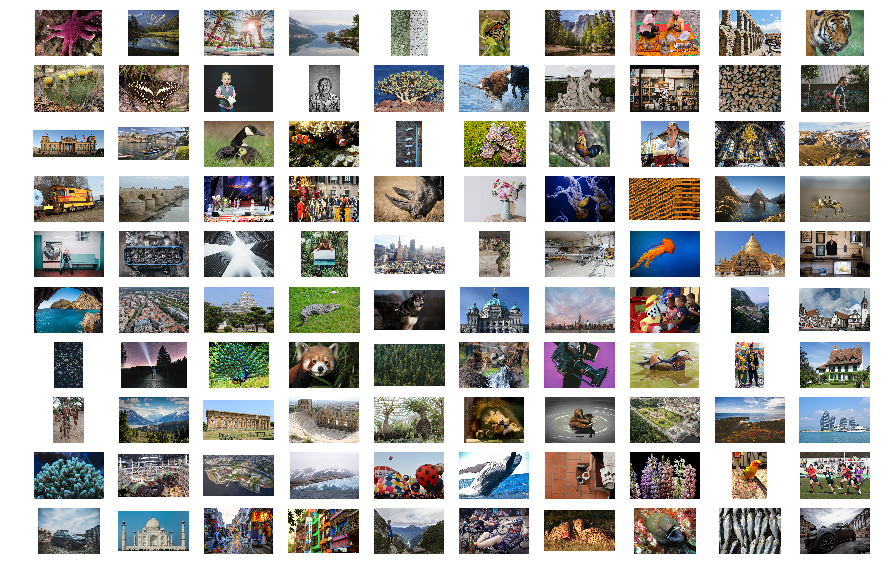

In [0]:
# Display sample training images
print('Some samples of training images ...')
plt.figure(figsize=(15,10))
ncols = 10;
nrows = 10;
for i in range(0, nrows):
  for j in range(0, ncols):
    id = i * ncols + j + 1
    im_lowres = Image.open(data_dir + '/Low_x4_Res_Train/{:04d}x4.png'.format(id))
    p = plt.subplot(nrows, ncols, id)
    p.imshow(im_lowres)
    p.axis('off')


## Training dataset augmentation.

The network mainly learns sub-region details. As a result, full images are of no particular interest during training. In order to benefit from this notion, the training images are essentially taken as large number of 96x96 subimages cropped from the full-sized images. For convenice and processing the training images and cropping them to prepare for training, following utility implementation is taken from one of the SRGAN implementations (namely, lefrtthomas's implementation [12]).

In [0]:
# Images loading utilities, courtesy of leftthomas (https://github.com/leftthomas/SRGAN/blob/master/data_utils.py)

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])


class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)


class ValDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, upscale_factor):
        super(ValDatasetFromFolder, self).__init__()
        self.upscale_factor = upscale_factor
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]

    def __getitem__(self, index):
        hr_image = Image.open(self.image_filenames[index])
        #print(hr_image.size)
        w, h = hr_image.size
        crop_size = calculate_valid_crop_size(min(w, h), self.upscale_factor)
        lr_scale = Resize(crop_size // self.upscale_factor, interpolation=Image.BICUBIC)
        hr_scale = Resize(crop_size, interpolation=Image.BICUBIC)
        hr_image = CenterCrop(crop_size)(hr_image)
        lr_image = lr_scale(hr_image)
        hr_restore_img = hr_scale(lr_image)
        return ToTensor()(lr_image), ToTensor()(hr_restore_img), ToTensor()(hr_image)

    def __len__(self):
        return len(self.image_filenames)


class TestDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, upscale_factor):
        super(TestDatasetFromFolder, self).__init__()
        self.lr_path = dataset_dir + '/SRF_' + str(upscale_factor) + '/data/'
        self.hr_path = dataset_dir + '/SRF_' + str(upscale_factor) + '/target/'
        self.upscale_factor = upscale_factor
        self.lr_filenames = [join(self.lr_path, x) for x in listdir(self.lr_path) if is_image_file(x)]
        self.hr_filenames = [join(self.hr_path, x) for x in listdir(self.hr_path) if is_image_file(x)]

    def __getitem__(self, index):
        image_name = self.lr_filenames[index].split('/')[-1]
        lr_image = Image.open(self.lr_filenames[index])
        w, h = lr_image.size
        hr_image = Image.open(self.hr_filenames[index])
        hr_scale = Resize((self.upscale_factor * h, self.upscale_factor * w), interpolation=Image.BICUBIC)
        hr_restore_img = hr_scale(lr_image)
        return image_name, ToTensor()(lr_image), ToTensor()(hr_restore_img), ToTensor()(hr_image)

    def __len__(self):
        return len(self.lr_filenames)

In [0]:
# Define Image Attributes for training
CROP_SIZE = 96
UPSCALE_FACTOR = 4

# Very small test dataset
# train_datadir = data_dir + '/High_Res_Train_Small'
# val_datadir = data_dir + '/High_Res_Val_Small'
# result_datadir = data_dir + '/Training_Results_Small'

train_datadir = data_dir + '/High_Res_Train'
val_datadir = data_dir + '/High_Res_Val'
result_datadir = data_dir + '/Training_Results'

train_dataset = TrainDatasetFromFolder(train_datadir, crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
val_dataset = ValDatasetFromFolder(val_datadir, upscale_factor=UPSCALE_FACTOR)
train_loader = DataLoader(dataset=train_dataset, num_workers=4, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, num_workers=4, batch_size=1, shuffle=False)

# SRGAN neural network architecture

SRGAN architecture consists of two adversarial networks. First is the deep generator network and the second is the deep discriminator network. The deep generator network is a stack of convolutional neural networks (CNN) trained to generate a super-resolution (SR) version of its low-resolution input image. On the other hand, the discriminator network is trained as a classifier to detect a generated super-resolution (SR) image from original high-resolution (HR) image. The generator and the discriminator are trained alternatively in order to train the combined network where generator creates as realistic as possible SR images that discriminator fails to classify as fake or false, and discrimiator trains to detect fakes images outputed from the generator.

![picture](https://drive.google.com/uc?export=view&id=1Qab9mI_EndxdT3lgpnCQC34Zz-6vcdDt)
*Figure 2: An overview of SRGAN adversial architecture shows how the Generator and Discriminator are trained together.*

## Deep generator network

At the core of the generator network is the “B residual blocks”, which the author of SRGAN[1] got inspired by *Perceptual loss* (*Johnson et al., 2016*) **[6]** and employs the block layout proposed by ResNets (*Gross and Wilber*, 2016) **[7]**. As described in SRGAN [1] architecture, each “B residual block” is composed of two CNN layers with 3 x 3 kernels and 64 feature maps, each followed by a batch-normalization layer. There is a skip connection from input to output in each “B residual block”.

There is a stack of five such “B residual blocks” which is sandwiched by additional blocks to complete the generator architecture in following manner:

 - A normal CNN block with 9x9 kernels and 64 feature maps to pre-process the image.
 - The stack of five “B residual blocks”. There is also a skip connection from beginning of the stack to output.
 - Followed by another single CNN block with 3x3 kernel and 64 feature maps.
 - Followed by two “Pixel shuffling blocks” (described below).
 - Finally, a single CNN block with 9x9 kernel and 3 channels to output image.

The “Pixel shuffling block” mentioned above is actually a subpixel convolutional neural network which come from a prior work by Shi et el. (2016) **[8]**. It is similar to regular CNN, however, it strides on subpixel levels that have been interpolated from the original input pixels. As a result, the block can actually increase the resolution of the output image. For example, striding with 0.5 pixel on 10 pixel width image results in 20 pixel output width. The two "Pixel shuffling blocks" would double the resolution of the SR image at the output. Hence, the generator outpus SR image of 4x resolution of the input image. shown below is the complete pipe-line of the network.

![picture](https://drive.google.com/uc?export=view&id=1MV_s0ldSu9eI1D8ZH_F5sIqgho91WAQH)
*Figure 3: Generator Network with corresponding kernel size (k), number of feature maps (n) and stride (s) indicated for each convolutional layer.Courtesy of SRGAN <cite data-cite="srgan2017">(Ledig et el, 2017)</cite>.*


In [0]:
# Create Generator Network
# Define submodules

class MainResBlock(nn.Module):
  def __init__(self, channels):
    super(MainResBlock, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(channels)
    self.prelu = nn.PReLU()
    self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(channels)

  def forward(self, x):
    residual = self.conv1(x)
    residual = self.bn1(residual)
    residual = self.prelu(residual)
    residual = self.conv2(residual)
    residual = self.bn2(residual)

    return x + residual
      
class PixelShuffler(nn.Module):
  def __init__(self, in_channels, up_scale):
    super(PixelShuffler, self).__init__()
    self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2,
                          kernel_size=3, padding=1)
    self.pixel_shuffle = nn.PixelShuffle(up_scale)
    self.prelu = nn.PReLU()

  def forward(self, x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x

# Generator 

class Generator(nn.Module):
  def __init__(self, scale_factor):
    super(Generator, self).__init__()
    self.block1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=9, padding=4),
                                nn.PReLU())
    self.block2 = MainResBlock(64)
    self.block3 = MainResBlock(64)
    self.block4 = MainResBlock(64)
    self.block5 = MainResBlock(64)
    self.block6 = MainResBlock(64)
    self.block7 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                nn.BatchNorm2d(64))
    nblocks = int(math.log(scale_factor, 2))
    block8 = [PixelShuffler(64, 2) for _ in range(nblocks)]
    self.block8 = nn.Sequential(*block8)
    self.block9 = nn.Conv2d(64, 3, kernel_size=9, padding=4) 
    
  def forward(self, x, verbose=False):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    block6 = self.block6(block5)
    block7 = self.block7(block6)
    if verbose: print('After block 7', block7.shape)
    block8 = self.block8(block1 + block7)
    if verbose: print('After block 8', block8.shape)
    block9 = self.block9(block8)
    if verbose: print('After block 9', block9.shape)
    return (torch.tanh(block9) + 1) / 2

In [0]:
test_gen = Generator(UPSCALE_FACTOR)
test_img = torch.randn(1,3,96,96)
out_img = test_gen(test_img, True)
print(out_img.shape)

After block 7 torch.Size([1, 64, 96, 96])
After block 8 torch.Size([1, 64, 384, 384])
After block 9 torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])


## Deep discriminator network

Discriminator network is similar to VGG **[10]** deep neural network classifier. It is trained to classify if the input image is fake SR image or real HR image based on the loss-function discussed further down. The network follows architecture from Radford et al. **[9]**, uses LeakyReLU (dropout alpha = 0.2) and does not use max-pooling anywhere. The distinguishing blocks in the network is the stack of 8 CNN layers with kernel size of 3x3, but with increasing number of kernels from 64 to 512. The network is stacked from input to output in following manner:

- A single CNN network without the  batch normalization.
- 7 CNN blocks consisting of:
- A CNN of 3x3 kernel, followed by a batch normalization.
- LeakyReLU with dropout probability of 0.2.
- Number of feature maps increase from 64 to 512 as shown in diagram below.
- The stride size alternates between one and two, as shown in diagram below.
- Two linear neural network with a LeakyReLU in between.
- Finally, a sigmoid function to classify the image.

The complete pipeline is illustrated in figure below.

![picture](https://drive.google.com/uc?export=view&id=1GA7exaZaTXyAWqjU3pTSIyMXmZ8NNyjj)
*Figure 4: Discriminator Network with corresponding kernel size (k), number of feature maps (n) and stride (s) indicated for each convolutional layer. Courtesy of SRGAN <cite data-cite="srgan2017">(Ledig et el, 2017)</cite>.*


In [0]:
# Discriminator

class ConvBlock(nn.Module):
  def __init__(self, input_size, output_size, stride):
    super(ConvBlock, self).__init__()
    self.conv = nn.Conv2d(input_size, output_size, kernel_size=3,
                          stride=stride, padding=1)
    self.bn = nn.BatchNorm2d(output_size)
    self.act = nn.LeakyReLU(0.2)
    
  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = self.act(x)
    return x

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1),
                             nn.LeakyReLU(0.2),
                             ConvBlock(64, 64, 2),
                             ConvBlock(64, 128, 1),
                             ConvBlock(128, 128, 2),
                             ConvBlock(128, 256, 1),
                             ConvBlock(256, 256, 2),
                             ConvBlock(256, 512, 1),
                             ConvBlock(512, 512, 2),
                             nn.AdaptiveAvgPool2d(1),
                             nn.Conv2d(512, 1024, kernel_size=1),
                             nn.LeakyReLU(0.2),
                             nn.Conv2d(1024, 1, kernel_size=1))
  
  def forward(self, x):
    batch_size = x.size(0)
    return torch.sigmoid(self.net(x).view(batch_size))

## Generator loss function

Loss function in generative super resolution is a bit tricky. A general mean-squared-error (MSE) loss function between the original HR image and generated SR image is not particularly useful alone, because the details in the generated SR image is not the original details present in HR. They look perceptually similar to human eyes, however they are not not pixel-wise close. The network isn't attempting to make SR image pixel-wise close either, but rather make them look similar. As a result, a loss function, known as "Perceptual loss function" that represents a measure of perceptual similarity is utilized instead. This is denoted by $l^{SR}_{VGG}$  and described in more detail in following subsection. 

$$l^{SR} =  l_{MSE} + 0.006\ l^{SR}_{VGG} + 0.001\ l_{Gen}^{SR}$$

In addtion, a small portion of an adversarial loss is also included in the total SR loss computation, denoted by $l_{Gen}^{SR}$ above. It is a general classifier cross-entropy loss of the discriminator when detecting the generated SR image to be a fake. Adversarial loss is given by:

$$l_{Gen}^{SR} = \sum_{n=1}^{N}(-log D(G(I^{LR})))$$

### Perceptual content loss using VGG loss-network

The more compilcated "Perceptual loss function", $l^{SR}_{VGG}$, relies on comparing the intermediate features found in a deep neural net classifier to be similar between the SR and HR images when classified through the said classifier. The idea being, if the images are similar at features level, they are more similar perceptually, even if individual pixels are not necessarily similar. A single layer output from a VGG16 pre-trained network is used in the original model to compute the features level loss, $l^{SR}_{VGG}$, and is given by:

$$l^{SR}_{VGG} = \frac{1}{W H} \sum_{x=1}^{W} \sum_{y=1}^{H} (\phi(I^{HR})_{x,y} - \phi(G(I^{LR}))_{x,y})^2$$

### Multi-layered perceptual loss model (our model)
In this new model, we introduce a new method where we build the perceptual loss from a weighted sum of multiple layers of the VGG16 network. Each of these feature layers are tapped and loss computed between the real HR and fake SR images. The weights $W_j$ that weight each layer are meant to be hyper-parameter and a good combination is found from different combination.

$$l^{SR}_{VGG} = \sum_{n=1}^{N}\sum_{j}(w_j l^{SR}_{VGG/j})$$

$$l^{SR}_{VGG/j} = \frac{1}{W_j H_j} \sum_{x=1}^{W_j} \sum_{y=1}^{H_j} (\phi_j(I^{HR})_{x,y} - \phi_j(G(I^{LR}))_{x,y})^2$$


In the above equation, the loss is computed as a basic MSE error between each feature layer $j$, denoted by $l^{SR}_{VGG/j}$ and are added up with a predefined weight $w_j$ specific to the layer. The CNN layers just before the pooling layers, just like picked in the original model, are used for loss computation. Following image illustrates the loss computation figuratively.

![picture](https://drive.google.com/uc?export=view&id=1Ujn916Fhji0akDEWO0AvM1Vnf58Ta9Vp)

*Figure 5: Loss network built from VGG16 that computes squared euclidean distance of all intermediate features as loss. The top VGG16 network takes real HR image and the bottom VGG16 takes generated SR image. The GAN network tries to reduce this loss in order to make the two images perceptually similar across all features. The same loss network can be done with VGG19.*


In [0]:
class GeneratorLoss(nn.Module):
  def __init__(self):
    super(GeneratorLoss, self).__init__()
    # Load two pre-trained VGG16 networks for loss computation.
    self.vggSR = vgg16(pretrained=True).eval()
    self.vggHR = vgg16(pretrained=True).eval()
    self.mse_loss = nn.MSELoss()
    self.bceloss = nn.BCELoss()
    self.vggSRactivation = {}
    self.vggHRactivation = {}
    self.losslayers = [3, 8, 15, 22, 29]
    self.losslayerweights = [0.1, 0.2, 0.2, 0.5]
    
    for j in self.losslayers:
      self.vggHR.features[j].register_forward_hook(self.get_activationSR(j))
      self.vggSR.features[j].register_forward_hook(self.get_activationHR(j))
    
  def get_activationSR(self, j):
    def hook(model, input, output):
        self.vggSRactivation[j] = output.detach()
    return hook
  
  def get_activationHR(self, j):
    def hook(model, input, output):
        self.vggHRactivation[j] = output.detach()
    return hook
    
  def forward(self, discrim_outs, out_images, target_images):
    self.vggSR(out_images)
    self.vggHR(target_images)
    loss = 0
    for interimOutputs,weight in zip(self.losslayers, self.losslayerweights):
        percep_loss = loss + weight*self.mse_loss(self.vggSRactivation[interimOutputs],
                                           self.vggHRactivation[interimOutputs])
    adversarial_loss = torch.mean(-torch.log(discrim_outs))
    image_loss = self.mse_loss(out_images, target_images)
    return image_loss + 0.006 * percep_loss + 0.001 * adversarial_loss

#Training and validation

There are several implementations of SRGAN available on Internet. Our implementation of SRGAN is mostly inspired by leftthomas's implementation [12] and the two TensorFlow implementations by brade31919[10] and tensorlayer[13]. Our implementation is heavily adapted to retain the original SRGAN network architecture elements, introduce our loss-computation methods, adapt to google colab training environment needs, implement training persistence, capture training results, changes related to python 3 and  vairous clean-ups to make the code consistent.

This was the hardest and most time consuming part of the whole project. A full training of 2000 epochs takes upwards of **48 hours** on K80 GPU. Due to limited running resource on google colab environment and available time in the project for debugging cycles, we have limited the training to 500 epochs, which still runs for **12 hours each**. We have used smaller datasets in the beginning in order to develop the algorithm and the code, and moved on the full dataset eventually.

Validation is performed using PSNR and SSIM metrics on the validation images set. These metrics are explained in more detail in section *Validation using PSNR and SSIM metrics* below.




In [0]:
# GPU Status
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  | Proc size: 524.8 MB
GPU RAM Free: 15069MB | Used: 10MB | Util   0% | Total 15079MB


### Validation using PSNR and SSIM metrics

The general trend to compare similarty between 2 images seem to be Peak-signal-to-noise-ratio (PSNR) **[14]** and Structural Similarity (SSIM) **[15]**. Both methods are quite standard mothods to compare two images and provide a numeric score. PSNR is computed using mean-squared-error (MSE) between the two images and has no limit to maximum. The higher the PSNR value, the higher the similarity. 

For images with 1.0 maximum value, PSNR is give by:

$$PSNR = 20\ log_{10} \big(\frac{1}{MSE}\big)$$

SSIM score computation is more involved and is better explained in wikipedia **[15]**. SSIM score is between 0 and 1.0, where 0 represents no similarity at all and 1.0 corresponds to only exact same image. Similarly, the higher the SSIM value, the higher the similarity. Pytorch-ssim library could not be used directly due to a bug in the version available in google colab. Hence, following implementation is used directly in this project.


In [0]:
# Image similarity metric, courtesy of Po-Hsun-Su (https://github.com/Po-Hsun-Su/pytorch-ssim)

from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

### Networks instantiation and persistant loading

In the following code cells, the SRGAN networks, optimizers and loss criterion are instantiated and initialized from last saved weights. If the training session was interrupted previously, it will resumes the training from last session. This is necessary because there were numerous arbitrary interruptions during a long session due to sync issues, space limitations, timeouts, kernel crashes etc..

In [0]:
# Instantiate networks
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

# Initilaize optimizer
optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

generator_criterion = GeneratorLoss()

x1 = torch.randn(5,3,96,96)
x2 = torch.randn(5,3,96,96)
dout = netD(x2)
print('Test discriminator output: ', dout)

gout = netG(x1)
output = generator_criterion(dout, x1, x1)
print('Test generator loss', output)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:18<00:00, 29716741.00it/s]


Test discriminator output:  tensor([0.5076, 0.5114, 0.5084, 0.5116, 0.5100], grad_fn=<SigmoidBackward>)
Test generator loss tensor(0.0007, grad_fn=<AddBackward0>)


In [0]:
# Load training weights from previous executions
NUM_EPOCHS = 500 
VALIDATION_EPOCH = 10
USE_PRETRAINED = True

MODELG_PATH = project_dir + '/SR_' + str(UPSCALE_FACTOR) + '_netG_weights_latest.pth'
MODELD_PATH = project_dir + '/SR_' + str(UPSCALE_FACTOR) + '_netD_weights_latest.pth'

if os.path.isfile(MODELG_PATH) and os.path.isfile(MODELD_PATH) and USE_PRETRAINED:
  netG.load_state_dict(torch.load(MODELG_PATH))
  netD.load_state_dict(torch.load(MODELD_PATH))
  print("Models Loaded")
else:
  print("No previous models and Pretraining False")


Models Loaded


In [0]:
# Load any unfinished session from previous execution
SESSION_PATH = project_dir + '/SR_' + str(UPSCALE_FACTOR) + '_session.txt'

TIMESTAMP = time.strftime("%Y%m%d_%H%M%S", time.localtime())
print('Timestamp: ' + TIMESTAMP)

epoch_results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': []}
val_results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}
last_epoch = 0

if os.path.isfile(SESSION_PATH):
  print('Unfinished session found: loading last session ...')
  
  lines = open(SESSION_PATH, 'r').readlines()
  print(lines)
  
  result = parse('Timestamp: {}, Last epoch: {:d}, Total epochs: {:d}', lines[0])
  TIMESTAMP = result[0]
  last_epoch = result[1]
  NUM_EPOCHS = result[2]
  
  print('Last session timestamp:', TIMESTAMP)
  print('Last session epoch: ', last_epoch)
  print('Last session total epochs: ', NUM_EPOCHS)
  
  result_path = result_datadir + '/SRF_' + str(UPSCALE_FACTOR) + '_' + TIMESTAMP
  out_path = result_path + '_statistics/'
  training_csv_file = out_path + 'srf_' + str(UPSCALE_FACTOR) + '_training_results_' + str(last_epoch) + '.csv'
  val_csv_file = out_path + 'srf_' + str(UPSCALE_FACTOR) + '_validation_results_' + str(last_epoch) + '.csv'
  
  print('Loading last training statistics from:')
  print(training_csv_file)
  print(val_csv_file)
  
  train_frame = pd.read_csv(training_csv_file)
  val_frame = pd.read_csv(val_csv_file)
  
  epoch_results['d_loss'] = list(train_frame['Loss_D'].values)
  epoch_results['g_loss'] = list(train_frame['Loss_G'].values)
  epoch_results['d_score'] = list(train_frame['Score_D'].values)
  epoch_results['g_score'] = list(train_frame['Score_G'].values)

  val_results['d_loss'] = list(val_frame['Loss_D'].values)
  val_results['g_loss'] = list(val_frame['Loss_G'].values)
  val_results['d_score'] = list(val_frame['Score_D'].values)
  val_results['g_score'] = list(val_frame['Score_G'].values)
  val_results['psnr'] = list(val_frame['PSNR'].values)
  val_results['ssim'] = list(val_frame['SSIM'].values)
  
  out_path = result_path + '_models/'
  g_path = out_path + 'netG_epoch_%d_%d.pth' % (UPSCALE_FACTOR, last_epoch)
  d_path = out_path + 'netD_epoch_%d_%d.pth' % (UPSCALE_FACTOR, last_epoch)
  
  print('Loading last model weights from:')
  print(g_path)
  print(d_path)
  netG.load_state_dict(torch.load(g_path))
  netD.load_state_dict(torch.load(d_path))


Timestamp: 20190519_080819
Unfinished session found: loading last session ...
['Timestamp: 20190518_162026, Last epoch: 220, Total epochs: 500']
Last session timestamp: 20190518_162026
Last session epoch:  220
Last session total epochs:  500
Loading last training statistics from:
/content/gdrive/My Drive/DeepLearningProject/data/Training_Results/SRF_4_20190518_162026_statistics/srf_4_training_results_220.csv
/content/gdrive/My Drive/DeepLearningProject/data/Training_Results/SRF_4_20190518_162026_statistics/srf_4_validation_results_220.csv
Loading last model weights from:
/content/gdrive/My Drive/DeepLearningProject/data/Training_Results/SRF_4_20190518_162026_models/netG_epoch_4_220.pth
/content/gdrive/My Drive/DeepLearningProject/data/Training_Results/SRF_4_20190518_162026_models/netD_epoch_4_220.pth


### Training method and execution

This is the most complex and slowest part of the implementation which takes several iterations to get right. In the very beginning, it uploads the network to the GPU in preparation to run the epoch iterations. Each epoch iteration consists of a training cycle, a validation cycle and session saving cycle.

#### Training cycle
The first part is the training cycle in each epoch loop. Each training cycle consists of two parts. The first part is the discriminator training backpropagated against the discriminator losses between real HR images of the training samples and fake SR images generated by the current Generator state. Second part is the training of the Generator against the generator loss computed in manner described in previous sections. In addtion, each training cycle also keeps record of discriminator and generator losses, and discriminator vs generator scores for plotting purposes performed later. 

#### Validation cycle
The second part of epoch iteration is the validation cycle where all validation images are evaluated using PSNR and SSIM scores. Couple of validation images are also saved in training directory for visual inspection. Each validation cycle records the mean PSNR and SSIM scores of the epoch for plotting purposes performed later. Validation cycle is only performed every Nth epoch iteration (N == VALIDATION_EPOCH in the implementation below) in order to save training time.

#### Session saving cycle
In this cycle, the current state of training is saved on disk. All the training and validation statistics, the network weights and the session information are saved in the training folder of the current timestamped execution. This will allow the training to continue from the session in the event of interruption.


In [0]:
# Continue to training execution.
# Make sure(!!) to run the previous cell if you want to continue the last session.

netG.to(device)
netD.to(device)
generator_criterion.to(device);

epoch_bar = tqdm(range(1 + last_epoch, NUM_EPOCHS + 1))
for epoch in epoch_bar:
  
    result_path = result_datadir + '/SRF_' + str(UPSCALE_FACTOR) + '_' + TIMESTAMP
    epoch_bar.set_description(desc='[%d/%d]'%(epoch, NUM_EPOCHS))
    train_bar = tqdm(train_loader, desc='Train', leave=False)

    # Set models in training mode
    netG.train()
    netD.train()
    
    train_results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': []}
    
    # Train for all data in training dataset
    for data, target in train_bar:
        
        train_bar.set_description(desc='[Train %d]'%(epoch))
        
        g_update_first = True
        batch_size = data.size(0)

        # (1) Update Discriminator network
        real_img = target.clone().detach().to(device=device)
        lowres_img = data.clone().detach().to(device=device)
        fake_img = netG(lowres_img)
        
        netD.zero_grad()
        real_out = netD(real_img)
        fake_out = netD(fake_img)

        discrim_fake_loss = torch.log(1 - fake_out)
        discrim_real_loss = torch.log(real_out)
        d_loss = torch.mean(-(discrim_fake_loss + discrim_real_loss))
        d_loss.backward(retain_graph=True)
        optimizerD.step()

        # (2) Update Generator network
        netG.zero_grad()
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()
        optimizerG.step()
        
        d_score = real_out.mean().item()
        g_score = fake_out.mean().item()
        train_results['g_loss'].append(g_loss.data.item())
        train_results['d_loss'].append(d_loss.data.item())
        train_results['d_score'].append(d_score)
        train_results['g_score'].append(g_score)

        del real_img, lowres_img, fake_img

    # Update epoch results record
    epoch_results['g_loss'].append(sum(train_results['g_loss'])/len(train_results['g_loss'])) 
    epoch_results['d_loss'].append(sum(train_results['d_loss'])/len(train_results['d_loss']))
    epoch_results['d_score'].append(sum(train_results['d_score'])/len(train_results['d_score']))
    epoch_results['g_score'].append(sum(train_results['g_score'])/len(train_results['g_score']))
    
    # Validate for all data in validation dataset
    if epoch % VALIDATION_EPOCH == 0 or epoch == 1:
    
      # Set models in evaluation mode
      netG.eval()
                                  
      # Folder location for generated images
      out_path = result_path + '_images/'
      if not os.path.exists(out_path):
          os.makedirs(out_path)

      val_images = []
      val_bar = tqdm(val_loader, desc='Val', leave=False)
      performance = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}

      for val_lr, val_hr_restore, val_hr in val_bar:
          
          lr = val_lr.clone().detach().to(device=device)
          hr = val_hr.clone().detach().to(device=device)
          sr = netG(lr)

          # Calculate and update model performance metrics
          batch_size = val_lr.size(0)
          batch_mse = ((sr - hr) ** 2).data.mean()
          batch_ssim = ssim(sr, hr).data.item()

          performance['batch_sizes'] += batch_size
          performance['mse'] += batch_mse * batch_size
          performance['ssims'] += batch_ssim * batch_size
          performance['psnr'] = 10 * log10(1 / (performance['mse'] / performance['batch_sizes']))
          performance['ssim'] = performance['ssims'] / performance['batch_sizes']

          val_images.extend(
              [display_transform()(val_hr_restore.squeeze(0)), 
               display_transform()(hr.data.cpu().squeeze(0)),
               display_transform()(sr.data.cpu().squeeze(0))])
          del hr, lr, sr

      # Update validation results record
      val_results['d_loss'].append(epoch_results['d_loss'][-1])
      val_results['g_loss'].append(epoch_results['g_loss'][-1])
      val_results['d_score'].append(epoch_results['d_score'][-1])
      val_results['g_score'].append(epoch_results['g_score'][-1])
      val_results['psnr'].append(performance['psnr'])
      val_results['ssim'].append(performance['ssim'])

      # Compose result images
      val_images = torch.stack(val_images)
      if val_images.size(0) < 15:
        chunks = 1
      else:
        chunks = val_images.size(0) // 15
      val_images = torch.chunk(val_images, chunks)
      val_save_bar = tqdm(val_images, desc='Save', leave=False)

      index = 1
      for image in val_save_bar:
          # Only save chunk 11 and 15 for previews. Rest could be generated later.
          if index == 11 or index == 15:
            image = utils.make_grid(image, nrow=3, padding=5)
            utils.save_image(image, out_path + 'epoch_%d_index_%d.png' % (epoch, index), padding=5)
          index += 1

      # Save model parameters
      torch.save(netG.state_dict(), MODELG_PATH)
      torch.save(netD.state_dict(), MODELD_PATH)
      
      out_path = result_path + '_models/'
      if not os.path.exists(out_path):
          os.makedirs(out_path)
          
      copyfile(MODELG_PATH, out_path + 'netG_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
      copyfile(MODELD_PATH, out_path + 'netD_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
      
      # Save training and validation losses
      out_path = result_path + '_statistics/'
      if not os.path.exists(out_path):
          os.makedirs(out_path)

      # Save training result statistics
      data_frame = pd.DataFrame(
          data={'Loss_D': epoch_results['d_loss'], 'Loss_G': epoch_results['g_loss'],
                'Score_D': epoch_results['d_score'], 'Score_G': epoch_results['g_score']},
          index=range(1, epoch + 1))
      csv_file = out_path + 'srf_' + str(UPSCALE_FACTOR) + '_training_results_' + str(epoch) + '.csv'
      data_frame.to_csv(csv_file, index_label='Epoch')

      # Save validation result statistics
      data_frame = pd.DataFrame(
          data={'Loss_D': val_results['d_loss'], 'Loss_G': val_results['g_loss'],
                'Score_D': val_results['d_score'], 'Score_G': val_results['g_score'],
                'PSNR': val_results['psnr'], 'SSIM': val_results['ssim']},
          index=range(1, epoch // VALIDATION_EPOCH + 2))
      csv_file = out_path + 'srf_' + str(UPSCALE_FACTOR) + '_validation_results_' + str(epoch) + '.csv'
      data_frame.to_csv(csv_file, index_label='Val batch no.')
      
      # Finally save current session (for possible recovery)
      session_file = open(SESSION_PATH, "w")
      session_file.write('Timestamp: %s, Last epoch: %d, Total epochs: %d' %(TIMESTAMP, epoch, NUM_EPOCHS))
      session_file.close()


## Training results and plots

Following code plots the training and validation losses and scores for both the evaluation networks. Their progresses could be inferred by studying these plots. They are further explained in detail beneath the plots. 

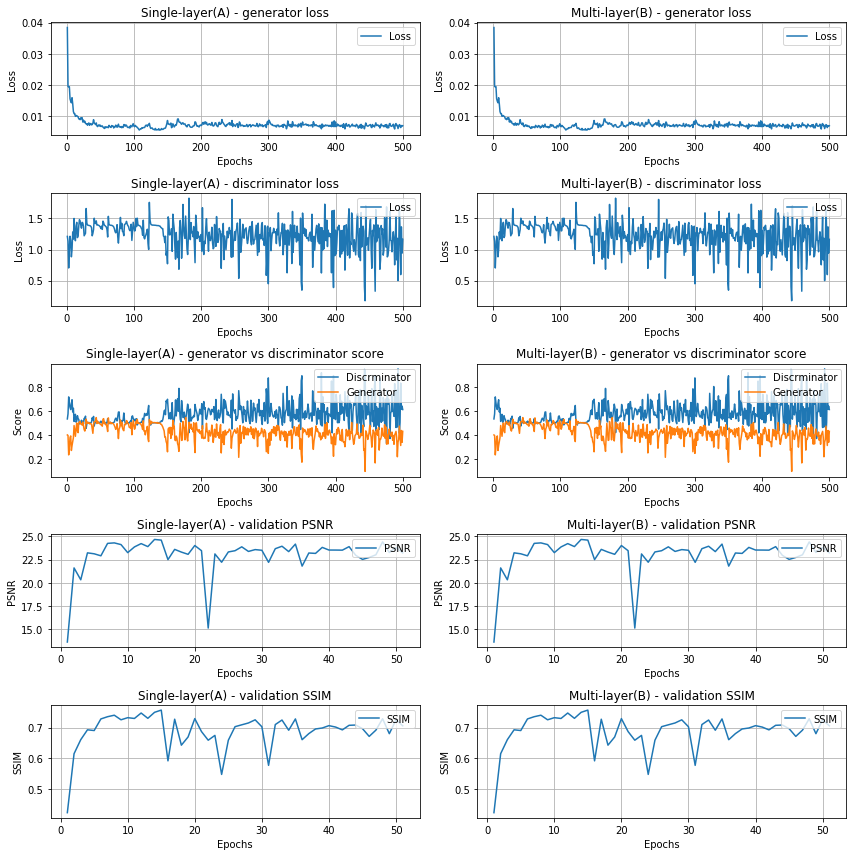

In [69]:
def plt_data(ax, d1, d2,LABEL, TITLE, YLABEL, XLABEL,fill=False):
  if fill == False:
    ax.plot(d1.flatten(), d2.flatten(), label=LABEL)
  else:
    ax.fill_between(d1.flatten(), d2.flatten(), label=LABEL)
  ax.set_title(TITLE)
  ax.legend(loc='upper right')
  ax.grid()
  ax.set_ylabel(YLABEL)
  ax.set_xlabel(XLABEL)

def plt_session(ax_all, col, label, train_csv, val_csv):
  train_read = pd.read_csv(train_csv)
  train_df_epoch = train_read[['Epoch']].values
  train_df_values = train_read[['Loss_D', 'Loss_G','Score_D', 'Score_G']].values

  val_read = pd.read_csv(val_csv)
  val_df_epoch = val_read[['Val batch no.']].values
  val_df_values = val_read[['PSNR', 'SSIM']].values

  plt_data(ax_all[0][col], train_df_epoch, train_df_values[:,1],
           'Loss', label + ' - generator loss','Loss','Epochs', False)
  plt_data(ax_all[1][col], train_df_epoch, train_df_values[:,0],
           'Loss', label + ' - discriminator loss','Loss','Epochs', False)
  plt_data(ax_all[2][col], train_df_epoch, train_df_values[:,2],
           'Discrminator',label + ' - generator vs discriminator score','Score','Epochs', False)
  plt_data(ax_all[2][col], train_df_epoch, train_df_values[:,3],
           'Generator', label + ' - generator vs discriminator score','Score','Epochs', False)
  plt_data(ax_all[3][col], val_df_epoch, val_df_values[:,0],
           'PSNR', label + ' - validation PSNR','PSNR','Epochs', False)
  plt_data(ax_all[4][col], val_df_epoch, val_df_values[:,1],
           'SSIM', label + ' - validation SSIM','SSIM','Epochs', False)

A_TRAIN_CSV = data_dir + "/Training_Results/SRF_4_20190518_162026_statistics/srf_4_training_results_500.csv"
A_VALID_CSV = data_dir + "/Training_Results/SRF_4_20190518_162026_statistics/srf_4_validation_results_500.csv"
B_TRAIN_CSV = data_dir + "/Training_Results/SRF_4_20190518_162026_statistics/srf_4_training_results_500.csv"
B_VALID_CSV = data_dir + "/Training_Results/SRF_4_20190518_162026_statistics/srf_4_validation_results_500.csv"

fig, ax_all = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))
plt_session(ax_all, 0, "Single-layer(A)", A_TRAIN_CSV, A_VALID_CSV)
plt_session(ax_all, 1, "Multi-layer(B)", B_TRAIN_CSV, B_VALID_CSV)
fig.tight_layout()

**Plots analysis:** From the plots above, it can be noted that Generator loss decreases rather quickly as training progresses. However, it seems to be hovering around 0.005 eventually, indicating that the generator has managed to get to macro-generation weights (which generatates most of the major details of the images). The further fluctuations are due to perceptual loss and fine-grained training against the discriminator.

The discriminator loss on the other hand seems to wildly fluctuate. In the beginning it would appear that discriminator is consistantly losing to generator -- loss increases and stay more or less high. However, as training progresses, it can be noted that the loss starts to fluctuate much stronger. This could mean that discriminater is trainning up in close adversial to the generator.

That is indeed the case as can be further seen in the 3rd plot of generator vs discriminator scores. The scores more or less converges and levels around the beginning of the training. As the training progresses, both the generator and discriminator can be see to strongly fluctuate in score, indicating close adversial between the two. PSNR and SSIM of the validation images can also be seen to quickly increase in the beginning and eventually also fluctuate during the adversial phase of the training.


# Experiment result

# Conclusion

# Future development

Super Resolution is a powerful tool enabled by deep-learning methods. SRGAN has evolved recently to many more improved versions.



#Biblography

[1] Ledig,C.,Theis,L.,Husza ́r,F.,Caballero,J.,Cunningham,A.,Acosta,A.,Aitken, A., Tejani, A., Totz, J., Wang, Z., et al.: Photo-realistic single image super- resolution using a generative adversarial network. In: CVPR. (2017)

[2] Bicubic interpolation. Available at: https://en.wikipedia.org/wiki/Image_scaling (accessed on 11.05.2019).

[3] Xintao Wang, Ke Yu, Shixiang Wu, Jinjin Gu, Yihao Liu, Chao Dong, Chen Change Loy, Yu Qiao, Xiaoou Tang, et al.: ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks. (2018)

[4] DIV2K dataset: DIVerse 2K resolution high quality images as used for the challenges @ NTIRE (CVPR 2017 and CVPR 2018) and @ PIRM (ECCV 2018). Available at: https://data.vision.ee.ethz.ch/cvl/DIV2K/ (accessed on: 11.05.2019)

[5] I.Goodfellow,J.Pouget-Abadie,M.Mirza,B.Xu,D.Warde-Farley, S. Ozair, A. Courville, and Y. Bengio. Generative adversarial nets. In Advances in Neural Information Processing Systems (NIPS). (2014) pages 2672–2680.

[6] J. Johnson, A. Alahi, and F. Li. Perceptual losses for real-time style transfer and super- resolution. In European Conference on Computer Vision (ECCV), pages 694–711. Springer, 2016.

[7] S. Gross and M. Wilber. 2016. Training and investigating residual nets. Available at http://torch.ch/blog/2016/02/04/resnets.html (accessed on 12.05.2019).

[8] Wenzhe Shi, Jose Caballero, Ferenc Huszar’ , Johannes Totz , Andrew P. Aitken , Rob Bishop , Daniel Rueckert , Zehan Wang. (2016) Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network.

[9] A. Radford, L. Metz, and S. Chintala. Unsupervised representation learning with deep convolutional generative adversarial networks. In International Conference on Learning Representations (ICLR), 2016.

[10] K. Simonyan and A. Zisserman. Very deep convolutional networks for large-scale image recognition. In International Conference on Learning Representations (ICLR), 2015.

[11] A TensorFlow implementation of SRGAN by brade31919. Available at: https://github.com/brade31919/SRGAN-tensorflow/ (Accessed on: 18.05.2019)

[12] A PyTorch implementation of SRGAN by leftthomas. Available at: https://github.com/leftthomas/SRGAN (Accessed on: 18.05.2019)

[13] Another TensorFlow implementation of SRGAN. Available at: https://github.com/tensorlayer/srgan (Accessed on: 19:05.2019)
